Import of libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # To standardize the data
import cvxpy as cp
from sklearn import linear_model

Import of the HMLasso function

In [2]:
### Adapt the path "C:/Users/Kilian/Desktop/ENSAE/STATAPP" to run the cell

import sys
sys.path.insert(1, 'C:/Users/Kilian/Desktop/ENSAE/STATAPP/Projet_Statapp/pretreatment')

import file_04_HMLasso as hml

## Data downloading and separation of the dataset

Dataset containing the types of each column from data_03.csv

In [3]:
columns_types = pd.read_csv("data_03_columns_types.csv", index_col=0)
columns_types.head(3)

,Name,Type
0,HHIDPN,Cont
1,HHID,Char
2,PN,Char


Downloading the data with social and genetic variables.

In [4]:
data = pd.read_csv("data_03.csv")

C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\3952530018.py:1: DtypeWarning: Columns (2684) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data_03.csv")


The column "genetic_Section_A_or_E" have mixed types, so we change its format.

In [5]:
temporary = np.where(data['genetic_Section_A_or_E'] == 'E', 1, np.where(data['genetic_Section_A_or_E'] == 'A', 0, np.nan))

In [6]:
data["genetic_Section_A_or_E"] = temporary

Now we add the health index created by t-SNE

In [7]:
tSNE_GHI = pd.read_csv("data_tSNE_GHI.csv")

We merge the t-SNE health index to the data

In [8]:
data = data.merge(tSNE_GHI, how ='left', on ='HHIDPN')

Here we test exogeneity, so we only keep individuals who were interviewed at all waves (14 waves)

In [9]:
data_bis = data.copy()

for i in range(1,15):
    data_bis = data_bis[data_bis['tSNE_GHI'+str(i)].notna()]

Number of individuals present in every waves.

In [10]:
tSNE_GHI[~tSNE_GHI.isnull().any(axis=1)].shape[0]

3396

We select the outcome tSNE_GHI

In [11]:
Y = data_bis[["HHIDPN"]+["tSNE_GHI" + str(i) for i in range (1,15)]]

We drop the previous health index GHIw from the data, which won't be used as outcome.
(list_columns_GHI contains the names of GHIw columns).

We drop the outcome to create the matrix X.

In [12]:
X = data_bis.drop(["GHI" + str(i) for i in range (1,15)], axis = 1)
X.drop(["tSNE_GHI" + str(i) for i in range (1,15)], axis = 1, inplace =True)

Now we split the dataset into training, validation and test sets.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state = 6)

## Machine learning

The objective here is to make a dataset where we observe if each variable exists at each wave

In [14]:
def dataset_temporal_variables (X_train,add_tSNE_GHIw):   
    temporal_variables = {}
    waves_columns = [col for col in X_train.columns if "genetic_" not in col and col[1] in "123456789"]
    for col in waves_columns:
      char = col[0] # R or H
      if col[2] in "01234":
        wave = col[1:3]
        suffix = col[3:]
      else:
        wave = col[1]
        suffix = col[2:]
      variable = char + 'w' + suffix

      if variable not in temporal_variables.keys():
        temporal_variables[variable] = np.zeros((14), dtype=bool)

      temporal_variables[variable][int(wave)-1] = True

    temporal_variables = pd.DataFrame(temporal_variables)

    # We manually add "tSNE_GHIw":
    if add_tSNE_GHIw and "tSNE_GHI1":
        temporal_variables["tSNE_GHIw"] = np.ones((14), dtype=bool)
        waves_columns += [f"tSNE_GHI{w}" for w in range(1,15)]
        
    return (temporal_variables,waves_columns)

In [15]:
# Timeless data
def timeless_variables(X_train,waves_columns):
    non_waves_columns = [col for col in X_train.columns if col not in waves_columns]
    To_remove = ["HHIDPN","PN","HHID","RAHHIDPN",'genetic_VERSION','genetic_Section_A_or_E']+["INW"+str(i+1) for i in range (14)]
    for x in To_remove:
        if x in non_waves_columns:
            non_waves_columns.remove(x)
    return non_waves_columns

We put the explaining variables by wave in a list of dataset Intemporal variables are put in each one of them

In [16]:
import random

def list_wave(X_train, reduced, gen_var):
    (temporal_variables , waves_columns) = dataset_temporal_variables(X_train,True)
    non_waves_columns = timeless_variables(X_train,waves_columns)
    
    non_waves_columns_no_genetic = [var for var in non_waves_columns if not('genetic_' in var)]
    
    #Reduce number of variables to code
    if reduced:
        temporal_variables_2 = temporal_variables.iloc[:,[i for i in range(1,15)]+[-i for i in range(1,5)]]
        non_waves_columns_2 = random.choices(non_waves_columns,k=5)
        non_waves_columns_no_genetic_2 = random.choices(non_waves_columns_no_genetic,k=5)

        liste = [] 
        for i in range(14):
            columns_wave_i = ["HHIDPN"]+[col.replace('w', str(i+1)) for col in temporal_variables_2.T[i].index[temporal_variables_2.T[i]] if col != "tSNE_GHIw"]
            #Add the intemporal variables only to the last wave, to avoid duplicated labels issues
            if i ==  13 and gen_var:
                liste.append(X_train.loc[X_train["INW"+str(i+1)] == 1, columns_wave_i + non_waves_columns_2])
            elif i == 13:
                liste.append(X_train.loc[X_train["INW"+str(i+1)] == 1, columns_wave_i + non_waves_columns_no_genetic_2])
            else:
                liste.append(X_train.loc[X_train["INW"+str(i+1)] == 1, columns_wave_i])
                
    #All the variables
    else:
        liste = []    # len = 14 
        for i in range(14):
            columns_wave_i = ["HHIDPN"]+[col.replace('w', str(i+1)) for col in temporal_variables.T[i].index[temporal_variables.T[i]] if col != "tSNE_GHIw"]
            #Intemporal variables only to the last wave, to avoid duplicated labels issues
            if i ==  13 and gen_var:
                liste.append(X_train.loc[X_train["INW"+str(i+1)] == 1, columns_wave_i + non_waves_columns])
            elif i == 13:
                liste.append(X_train.loc[X_train["INW"+str(i+1)] == 1, columns_wave_i + non_waves_columns_no_genetic])
            else:
                liste.append(X_train.loc[X_train["INW"+str(i+1)] == 1, columns_wave_i])
                
    return (liste)
    

### Lasso selection

We start to initialize with a first lasso on the first wave.

In [17]:
def initialize_Lasso(liste, Y_train, HMLasso, method, mu, limit,print_wave):
    
    if print_wave:
        print("wave",1)
    
    scaler = StandardScaler()#(with_std=False)
    hml.ERRORS_HANDLING = "ignore"
    
    #Prepare data
    Y_train1 = Y_train.iloc[:,[0,1]]
    Y_columns = Y_train1.columns
    Y_train1.dropna(axis =0, inplace =True)
    X_Y_tempo = liste[0].merge(Y_train1, how = "left", on = "HHIDPN")
    X_train1 = X_Y_tempo.drop(Y_columns, axis=1)
    Y_train1 = X_Y_tempo[Y_train1.columns[0]]
    Y_train1 = Y_train1.values
    Y_train1 = (Y_train1 - np.mean(Y_train1))/np.std(Y_train1)
    
  
    #HMLasso
    if HMLasso:
        #Standardize X_train
        X_train1 = scaler.fit_transform(X_train1)
        
        coefficients = apply_HMLasso(X_train1, Y_train1,mu)
        
        #Variables to keep
        var_to_keep = coefficients > 10**(limit)
    
    #Common Lasso
    else:
        X_train1 = Na_imputation(X_train1, method)
        
        #Standardize X_train
        X_train1 = scaler.fit_transform(X_train1)
        
        (coefficients, Resid) = apply_Lasso(X_train1, Y_train1, mu)
        
        #Variables top keep
        var_to_keep = coefficients != 0
        
        

    #Selection of variables
    if print_wave:
        print("Variables kept :", list(var_to_keep).count(1))
    var_to_keep = np.insert(var_to_keep,0,True)
    
    entire_data = liste[0]
    selected = entire_data[entire_data.columns[var_to_keep]]
        
    return (selected,Resid)

In [18]:
def apply_HMLasso(X, Y, mu):
    
    lasso = hml.HMLasso(mu)
    lasso.fit(X, Y)
    
    coefficients = np.abs(lasso.beta_opt.copy())
    
    return coefficients

def apply_Lasso(X,Y, mu):
    
    clf = linear_model.Lasso(alpha=mu)
    clf.fit(X, Y)
    
    coefficients = clf.coef_
    
    #Correlation between residuals and X
    Y_hat = clf.predict(X)
    Resid = Y - Y_hat
    
    return (coefficients, Resid)

In [19]:
def Na_imputation(X, method):
    if method == "mean":
        return X.fillna(X.mean())

function to impute missing data created when merging by mean but without touching Na values already there before the merge.

In [20]:
def Na_management(df1, df2, index):
    
    merged = df1.merge(df2, how='outer', on = index)
    
    df1_index = df1.set_index(index)
    df2_index = df2.set_index(index)
    
    merged = merged.fillna(merged.mean())
    merged = merged.set_index(index)
    
    df1_index = df1_index.fillna("NaN")
    merged.update(df1_index)
    
    df2_index = df2_index.fillna("NaN")
    merged.update(df2_index)
    
    merged = merged.replace("NaN",np.nan)
    
    merged = merged.reset_index()
    
    return merged

Function to select variables by HMLasso

In [21]:
def Lasso_selection(X_train, Y_train, HMLasso, method, mu, limit, reduced, print_wave, gen_var):
    
    #If a columns contains only Nan values, we drop it
    empty_col = [col for col in X_train.columns if X_train[col].isnull().all()]
    if empty_col != []:
        X_train.drop(empty_col, axis=1, inplace=True)
    
    liste = list_wave(X_train, reduced, gen_var)
    
    if print_wave:
        print("Lasso selection, mu =", mu)
    
    
    (selected, Wave_1) = initialize_Lasso(liste, Y_train, HMLasso, method, mu, limit,print_wave)
    
    Residuals = pd.DataFrame({"Wave_1" : Wave_1})
    
    print(Residuals)
    
    scaler = StandardScaler()#(with_std=False)
    hml.ERRORS_HANDLING = "ignore"
    
    for i in range (1,14) :
        
        if print_wave:
            print("wave",i+1)

        var_to_select = Na_management(selected, liste[i], "HHIDPN")

        Y_train_i = Y_train.iloc[:,[0,i+1]]
        Y_columns = Y_train_i.columns
        X_Y_train = var_to_select.merge(Y_train_i, how = 'left', on = "HHIDPN")

        Y_train_i = X_Y_train[Y_columns[0]]
        X_train_i = X_Y_train.drop(Y_columns, axis =1)

        Y_train_i = Y_train_i.fillna(Y_train_i.mean())
        Y_train_i = Y_train_i.values
        Y_train_i = (Y_train_i - np.mean(Y_train_i))/np.std(Y_train_i)

        
        #HMLasso
        if HMLasso:
            #Standardize X_train
            X_train_i = scaler.fit_transform(X_train_i)
        
            coefficients = apply_HMLasso(X_train_i, Y_train_i, mu)
        
            #Variables to keep
            var_to_keep = coefficients > 10**(limit)
            
        #Common Lasso
        else:
            X_train_i = Na_imputation(X_train_i, method)
        
            #Standardize X_train
            X_train_i = scaler.fit_transform(X_train_i)

            (coefficients, resid) = apply_Lasso(X_train_i, Y_train_i, mu)
            
            Residuals["Wave_"+str(i+1)] = resid
            #Variables top keep
            var_to_keep = coefficients != 0
            
        #Selection of variables
        if print_wave:
            print("Variables kept :", list(var_to_keep).count(1))
        var_to_keep = np.insert(var_to_keep,0,True)

        entire_data = var_to_select
        selected = entire_data[entire_data.columns[var_to_keep]] 
        
    Test = test_resid(liste, Residuals)
    
    #Return the data with selected variables, the number of variables selected and the names of columns
    return (selected, selected.columns, Test)

In [22]:
from scipy.stats import pearsonr

def test_resid(liste, residuals):
    #start by separating residuals in temporal residuals and non temporal
    columns_r = residuals.columns
    residuals["MEAN"] = residuals[columns_r].sum(axis=1)/14
    TEST = []
    for k in range(0, 14): 
        Test = pd.DataFrame()
        X_t = liste[k]
        X_t = X_t.fillna(X_t.mean())
        P_stat , p_value = [] , []
        noms = [x for x in X_t.columns if x != "HHIDPN"]
        for j in range(0,14):
            for x in X_t.columns:
                P_test = list(pearsonr(X_t[x],residuals["Wave_"+str(j+1)]))
                P_stat.append(P_test[0])
                p_value.append(P_test[1])
                Test = pd.DataFrame(data = { 'Correlation' : P_stat , 'p_value' : p_value})
            TEST.append(Test)
    return TEST
                
  
            

In [23]:
L = np.array([1,2])
K = [3,4]
M =[L,K]
L - 2
L

array([1, 2])

### Within estimator

There two types of missing values, the "one-time" missing values when someone didn't awnser a question during the interview or so and the missing values when someone wasn't interviewed at all during a wave.


For the first type, we impute those missing values with the mean of the column (Nan).
(Possibility to work on another imputation method).

Then for the individuals who weren't interviewed during a wave, we replace the missing value with the temporal mean of the variable over time (NanNan)


Finally, we compute X_vague_ti = X_ti - temporal_mean(X_ti)

In [24]:
def creation_data_within(selected, Lasso_before_within):
    
    if not(Lasso_before_within):
        selected = selected.drop(["INW"+str(i) for i in range(1,15)], axis =1)
    #For the "one-time" missing values imputation by mean
    X_train_within = selected.fillna(selected.mean())
    ###For people who weren't interviewed
    
    # We start by adding the INWw columns to know if the individual was interviewed during the wave w
    X_train_within = X_train_within.merge(X_train[["HHIDPN"]+["INW"+str(i) for i in range(1,15)]], how ="left", on="HHIDPN")  

    #We recover the missing values for people who weren't interviewed during the wave w
    X_train_within = recover_missing(X_train_within)
    
    # Creation of the data set for within regression.
    (X_train_within, temporal_variables_within) = data_set_within(X_train_within)
    
    #Still Nan values in intemporal variables
    X_train_within = X_train_within.fillna(X_train_within.mean())
    
    return (X_train_within, temporal_variables_within)

This function return a dataset containing only variables concerned by the wave.

In [25]:
import re
import pickle

def get_wave(data, wave, non_temporal):
  """
  This function returns a smaller dataset summarizing all data for the given wave.

  Note that it also returns columns that are not relative to any wave (for instance, 'HHIDPN')
  """

  assert wave in range(1, 15)

  regex = re.compile("[0-9]+")
  if non_temporal:
        wave_columns = [col for col in data.columns if (len(regex.findall(col)) == 0 or regex.findall(col)[0] == str(wave))]
  else:
        wave_columns = [col for col in data.columns if (regex.findall(col) != [] and regex.findall(col)[0] == str(wave))]
  wave_data = data[wave_columns]

  return wave_data

Function to recover the missing values for people who weren't interviewed during the wave w

In [26]:
def recover_missing(X_train_within):

    X_train_within_index = X_train_within.set_index("HHIDPN")
    wave_1 = get_wave(X_train_within_index,1, non_temporal =False)
    wave_1.loc[wave_1["INW1"] == 0] = np.nan
    wave_1["INW1"].fillna(0)
    Tempo = wave_1

    for i in range(2,15):
        if i == 14:
            wave_i = get_wave(X_train_within_index, i, non_temporal =True)
        else:
            wave_i = get_wave(X_train_within_index, i, non_temporal =False)
        wave_i.loc[wave_i["INWw".replace('w', str(i))] == 0] = np.nan
        wave_i["INWw".replace('w', str(i))].fillna(0)
        Tempo = Tempo.merge(wave_i, how= "left", on = "HHIDPN")

    return Tempo.reset_index()

Get a dataframe to know which variables are in X_train_within

Function to compute (A faire en latex) X_vague_ti = X_ti - temporal_mean(X_ti) if the temporal variable is present in at least two waves.

It creates columns containing the temporal mean of a temporal variables and then replaces the Nan values (when people weren't interviewed) by this mean. Finally it creates the dataset  X_vague_ti.

In [27]:
def data_set_within (X_train_within):
    
    temporal_variables_within = dataset_temporal_variables(X_train_within, False)[0]
    
    X_within = X_train_within.copy()
    temporal_variables_within_actualised = temporal_variables_within.copy()
    i = 0
    
    for col in temporal_variables_within.columns:
        i += 1
        if i%10 == 0:
            print(i, "out of ", len(temporal_variables_within.columns))
        index_wave = temporal_variables_within.index[temporal_variables_within[col]==1].tolist()
        names_waves = [col.replace('w', str(i+1)) for i in index_wave]
        
        # Only if the temporal variable is present in at least two waves
        if len(names_waves)>1:
            # (~X_within[names_waves].isna()).sum(axis=1) = number of non missing values
            X_within[col+"_MEAN"] = X_within[names_waves].sum(axis=1)/(~X_within[names_waves].isna()).sum(axis=1)
            for x in names_waves:
                # Imputing the missing values by the temporal mean
                X_within[x].fillna(X_within[col+"_MEAN"], inplace= True)         
                #Creating the new data for within regression X_vague
                X_within[x+"_Within"] = X_within[x] - X_within[col+"_MEAN"]
                X_within.drop(x, inplace=True, axis=1)
        
        else:
            temporal_variables_within_actualised = temporal_variables_within_actualised.drop(col, axis=1)
    return (X_within, temporal_variables_within_actualised)

Now we do the same thing to Y_train but no need to impute the Nan values since the only outcome is tSNE_GHI14 (no Nan).

In [28]:
def creation_outcome_within(Y_train):

    Y_train_within = Y_train.copy()
    
    tSNE_GHI = [f"tSNE_GHI{w}" for w in range(1,15)]

    Y_train_within["tSNE_GHIw_MEAN"] = Y_train_within[tSNE_GHI].sum(axis=1)/(~Y_train_within[tSNE_GHI].isna()).sum(axis=1)
    for col in tSNE_GHI:
        Y_train_within[col+"_within"] = Y_train_within[col] - Y_train_within["tSNE_GHIw_MEAN"]
    
    return Y_train_within

We can now proceed to the regression

In [29]:
def get_X_Y_within(X_train_within, Y_train_within, temporal_variables_within, Lasso_before_within):
    
    data_regression = X_train_within.merge(Y_train_within[["HHIDPN","tSNE_GHI14_within"]], on = "HHIDPN")
    Y_regression = data_regression["tSNE_GHI14_within"]
    list_to_drop = ["HHIDPN","tSNE_GHI14_within"]
    if Lasso_before_within:
        list_to_drop = list_to_drop + [col+"_MEAN" for col in temporal_variables_within.columns]+["INW"+str(i) for i in range(1,15)]
        
    X_regression = data_regression.drop(list_to_drop,axis=1)
    
    return (X_regression, Y_regression)
    

In [30]:
from sklearn.linear_model import LinearRegression

def regression(X_regression,Y_regression):
    
    modeleReg=LinearRegression()

    modeleReg.fit(X_regression,Y_regression) 
    
    return modeleReg

In [31]:
def Within_estimates(X, Y, HMLasso, Lasso_before_within, method, mu, limit, reduced, print_wave, gen_var):
    
    if Lasso_before_within:
        (selected, names_var, Test) = Lasso_selection(X, Y, HMLasso, method, mu, limit, reduced, print_wave, gen_var)

        (X_within, temporal_variables_within) = creation_data_within(selected,Lasso_before_within)
        Y_within = creation_outcome_within(Y_train)

        (X_regression, Y_regression) = get_X_Y_within(X_within, Y_within, temporal_variables_within, Lasso_before_within)
        
    else:
        
        (selected, names_var, Test) = Lasso_selection(X, Y, HMLasso, method, mu, limit, reduced, print_wave, gen_var)
        
        temporal_variables_within = dataset_temporal_variables(selected, False)[0]
        #Still Nan values in intemporal variables
        selected_2 = selected.fillna(selected.mean())
        (X_regression, Y_regression) = get_X_Y_within(selected_2, Y, temporal_variables_within, Lasso_before_within)
    
    return (regression(X_regression,Y_regression), names_var, X_regression, Y_regression, Test)

### Optimisation of parameters with validation set

In [32]:
def summary_model (X_train, Y_train, X_valid, Y_valid, HMLasso, Lasso_before_within, method, mu, limit, reduced, coef, print_wave, gen_var):
    
    (model, names_var, X_regression, Y_regression, Test) = Within_estimates(X_train, Y_train, HMLasso, Lasso_before_within, method, mu, limit, reduced, print_wave, gen_var)
    
    if Lasso_before_within:
        #Selection of columns in the validation set
        selected_valid = X_valid[list(names_var)]

        (X_valid_within, temporal_variables_within) = creation_data_within(selected_valid, Lasso_before_within)
        Y_valid_within = creation_outcome_within(Y_valid)

        (X_valid_regression, Y_valid_regression) = get_X_Y_within(X_valid_within, Y_valid_within, temporal_variables_within, Lasso_before_within)
        
    else:
        
        selected_valid = X_valid[list(names_var)]
        #Still Nan values in intemporal variables
        selected_valid_2 = selected_valid.fillna(selected_valid.mean())
        temporal_variables_within = dataset_temporal_variables(selected_valid, False)[0]
        
        (X_valid_regression, Y_valid_regression) = get_X_Y_within(selected_valid_2, Y_valid, temporal_variables_within, Lasso_before_within)
        
    
    R_square_train = r_squared(X_regression, Y_regression, model)
    R_square_valid = r_squared(X_valid_regression, Y_valid_regression, model)
    
    intercept = model.intercept_
    coefficients = model.coef_
    
    RMSE_train = RMSE(X_regression, Y_regression, model)
    RMSE_valid = RMSE(X_valid_regression, Y_valid_regression, model)

    if coef:
        summary = {"HMLasso" : HMLasso, "mu" : mu, "Lasso_before_within" : Lasso_before_within, "R_square_train" : R_square_train, "RMSE_train" : RMSE_train, "R_square_valid" : R_square_valid, "RMSE_valid" : RMSE_valid, "variables kept": len(list(names_var)), "intercept" : intercept, "coefficients" : coefficients}
        return (summary, model, names_var, Test)
    
    else:
        summary = {"HMLasso" : HMLasso, "mu" : mu, "Lasso_before_within" : Lasso_before_within, "R_square_train" : R_square_train, "RMSE_train" : RMSE_train, "R_square_valid" : R_square_valid, "RMSE_valid" : RMSE_valid, "variables kept": len(list(names_var))}
        return (summary, model, names_var, Test)

In [33]:
from sklearn.metrics import r2_score

def r_squared(X, Y, model):
    Y_predict = model.predict(X)
    
    r2 = r2_score(Y, Y_predict)
    
    return r2

In [34]:
from sklearn.metrics import mean_squared_error

def RMSE(X, Y, model):
    Y_predict = model.predict(X)
    
    MSE = mean_squared_error(Y, Y_predict)
    
    return MSE

In [35]:
def multiples_models(X_train, Y_train, X_valid, Y_valid, list_mu, HMLasso, Lasso_before_within, method, limit, reduced, print_wave, gen_var):
    
    Frame = pd.DataFrame(columns = ["HMLasso", "mu", "Lasso_before_within", "R_square_train", "RMSE_train", "R_square_valid", "RMSE_valid", "variables kept"])
    list_model = []
    list_var = []
    
    for mu in list_mu:
        (summary_ML, model, names_var, Test) = summary_model(X_train, Y_train, X_valid, Y_valid, HMLasso, Lasso_before_within, method, mu, limit, reduced, coef=False, print_wave=print_wave, gen_var=gen_var)
        Frame = Frame.append(summary_ML, ignore_index=True)
        list_model.append(model)
        list_var.append(names_var)
        
    return (Frame, list_model, list_var,Test)

### Application on test set

In [36]:
def test_model (X_test, Y_test, model, names_var, Lasso_before_within):
    
    if Lasso_before_within:
        #Selection of columns in the validation set
        selected_test = X_test[list(names_var)]

        (X_test_within, temporal_variables_within) = creation_data_within(selected_test, Lasso_before_within)
        Y_test_within = creation_outcome_within(Y_test)

        (X_test_regression, Y_test_regression) = get_X_Y_within(X_test_within, Y_test_within, temporal_variables_within, Lasso_before_within)
    
    else:
        selected_test = X_test[list(names_var)]
        temporal_variables_within = dataset_temporal_variables(selected_test, False)[0]
        #Still Nan values in intemporal variables
        selected_test_2 = selected_test.fillna(selected_test.mean())
        (X_test_regression, Y_test_regression) = get_X_Y_within(selected_test_2, Y_test, temporal_variables_within, Lasso_before_within)
    
    R_square_test = model.score(X_test_regression,Y_test_regression, sample_weight=None)
    
    RMSE_test = RMSE(X_test_regression, Y_test_regression, model)
    
    return {"R_square_test" : R_square_test, "RMSE_test" : RMSE_test}


## Application

In [37]:
list_mu = [0.01100]

In [38]:
(Frame_test, list_model_test, list_var_test, Test) = multiples_models(X_train, Y_train, X_valid, Y_valid, list_mu, HMLasso =False, Lasso_before_within =True, method ="mean", limit= -14, reduced =False, print_wave =True, gen_var =True)

Lasso selection, mu = 0.011
wave 1


C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\1943930034.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train1.dropna(axis =0, inplace =True)


Variables kept : 2
        Wave_1
0     0.001137
1    -0.006983
2    -0.005023
3    -0.000107
4    -0.003993
...        ...
2711 -0.000920
2712  0.013195
2713 -0.005254
2714 -0.014189
2715  0.019516

[2716 rows x 1 columns]
wave 2
Variables kept : 3
wave 3
Variables kept : 3
wave 4
Variables kept : 5
wave 5
Variables kept : 5
wave 6
Variables kept : 5
wave 7
Variables kept : 6
wave 8
Variables kept : 7
wave 9
Variables kept : 7
wave 10
Variables kept : 7
wave 11
Variables kept : 7
wave 12
Variables kept : 9
wave 13
Variables kept : 9
wave 14
Variables kept : 9


C:\Users\Kilian\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\2199017923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_1.loc[wave_1["INW1"] == 0] = np.nan
C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\2199017923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_i.loc[wave_i["INWw"

C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\2199017923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_i.loc[wave_i["INWw".replace('w', str(i))] == 0] = np.nan
C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\2199017923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_i.loc[wave_i["INWw".replace('w', str(i))] == 0] = np.nan
C:\Users\Kilian\AppData\Local\Temp\ipykernel_10700\2199017923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [46]:
liste_p = []
for x in Test:
    liste_p.append(len(x[x["p_value"]>= 0.95]))
liste_p


[51,
 102,
 153,
 204,
 255,
 306,
 357,
 408,
 459,
 510,
 561,
 612,
 663,
 714,
 58,
 116,
 174,
 232,
 290,
 348,
 406,
 464,
 522,
 580,
 638,
 696,
 754,
 812,
 35,
 70,
 105,
 140,
 175,
 210,
 245,
 280,
 315,
 350,
 385,
 420,
 455,
 490,
 28,
 56,
 84,
 112,
 140,
 168,
 196,
 224,
 252,
 280,
 308,
 336,
 364,
 392,
 26,
 52,
 78,
 104,
 130,
 156,
 182,
 208,
 234,
 260,
 286,
 312,
 338,
 364,
 34,
 68,
 102,
 136,
 170,
 204,
 238,
 272,
 306,
 340,
 374,
 408,
 442,
 476,
 32,
 64,
 96,
 128,
 160,
 192,
 224,
 256,
 288,
 320,
 352,
 384,
 416,
 448,
 23,
 46,
 69,
 92,
 115,
 138,
 161,
 184,
 207,
 230,
 253,
 276,
 299,
 322,
 18,
 36,
 54,
 72,
 90,
 108,
 126,
 144,
 162,
 180,
 198,
 216,
 234,
 252,
 29,
 58,
 87,
 116,
 145,
 174,
 203,
 232,
 261,
 290,
 319,
 348,
 377,
 406,
 26,
 52,
 78,
 104,
 130,
 156,
 182,
 208,
 234,
 260,
 286,
 312,
 338,
 364,
 24,
 48,
 72,
 96,
 120,
 144,
 168,
 192,
 216,
 240,
 264,
 288,
 312,
 336,
 64,
 128,
 192,
 256,
 32

<AxesSubplot:>

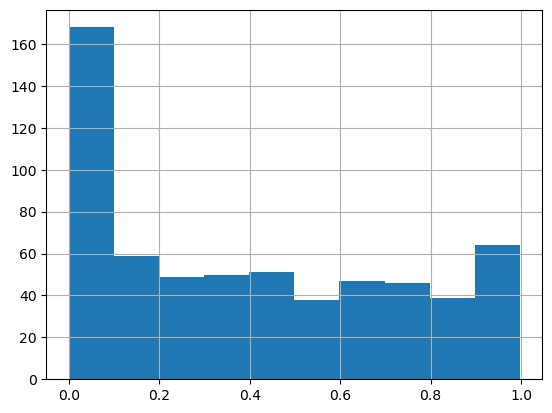

In [85]:
Test[0]["p_value"].hist()

In [75]:
Frame_4

,HMLasso,mu,R_square_train,RMSE_train,R_square_valid,RMSE_valid,variables kept
0,False,0.01080,0.093994,1283.853333,0.082117,1310.533455,243
1,False,0.01084,0.093247,1284.911427,0.081866,1310.890997,241
2,False,0.01088,0.093199,1284.979462,0.082063,1310.609390,240
3,False,0.01092,0.093148,1285.051891,0.082387,1310.147937,239
4,False,0.01096,0.093142,1285.060002,0.082103,1310.553125,238
5,False,0.01100,0.092702,1285.684546,0.082827,1309.518518,235
6,False,0.01104,0.092697,1285.691428,0.082741,1309.642447,234
7,False,0.01108,0.092466,1286.018068,0.080824,1312.378395,232
8,False,0.01112,0.092416,1286.090082,0.080732,1312.509812,231
9,False,0.01116,0.091695,1287.111061,0.078579,1315.584714,229


In [ ]:
print("train")
(X_within_train, temporal_variables_within) = creation_data_within(X_train, Lasso_before_within = False)
Y_within_train = creation_outcome_within(Y_train)
        
#Remove column containing the temporal mean
list_to_drop = [col+"_MEAN" for col in temporal_variables_within.columns]+["INW"+str(i) for i in range(1,15)]
X_within_train = X_within_train.drop(list_to_drop,axis=1)
list_to_keep = [f"tSNE_GHI{w}_within" for w in range(1,15)]+["HHIDPN"]
Y_within_train = Y_within_train[list_to_keep]

#Problem with "INWw" columns
X_within_train = X_within_train.merge(X_train, on="HHIDPN")


print("valid")
(X_within_valid, temporal_variables_within) = creation_data_within(X_valid, Lasso_before_within = False)
Y_within_valid = creation_outcome_within(Y_valid)
        
#Remove column containing the temporal mean
list_to_drop = [col+"_MEAN" for col in temporal_variables_within.columns]+["INW"+str(i) for i in range(1,15)]
X_within_valid = X_within_valid.drop(list_to_drop,axis=1)
list_to_keep = [f"tSNE_GHI{w}_within" for w in range(1,15)]+["HHIDPN"]
Y_within_valid = Y_within_valid[list_to_keep]
  
#Problem with "INWw" columns
X_within_valid = X_within_valid.merge(X_valid, on="HHIDPN")
    
print("test")
(X_within_test, temporal_variables_within) = creation_data_within(X_test, Lasso_before_within = False)
Y_within_test = creation_outcome_within(Y_test)
        
#Remove column containing the temporal mean
list_to_drop = [col+"_MEAN" for col in temporal_variables_within.columns]+["INW"+str(i) for i in range(1,15)]
X_within_test = X_within_test.drop(list_to_drop,axis=1)
list_to_keep = [f"tSNE_GHI{w}_within" for w in range(1,15)]+["HHIDPN"]
Y_within_test = Y_within_test[list_to_keep]

#Problem with "INWw" columns
X_within_test = X_within_test.merge(X_test, on="HHIDPN")

In [40]:
X_within_train.to_csv('X_within_train.csv',sep = ',', index=False)
Y_within_train.to_csv('Y_within_train.csv',sep = ',', index=False)
X_within_valid.to_csv('X_within_valid.csv',sep = ',', index=False)
Y_within_valid.to_csv('Y_within_valid.csv',sep = ',', index=False)
X_within_test.to_csv('X_within_test.csv',sep = ',', index=False)
Y_within_test.to_csv('Y_within_test.csv',sep = ',', index=False)

In [24]:
X_within_train = pd.read_csv('X_within_train.csv')
Y_within_train = pd.read_csv('Y_within_train.csv')
X_within_valid = pd.read_csv('X_within_valid.csv')
Y_within_valid = pd.read_csv('Y_within_valid.csv')
X_within_test = pd.read_csv('X_within_test.csv')
Y_within_test = pd.read_csv('Y_within_test.csv')